Imports

In [75]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
sns.set()


Load Data

In [77]:
def load_data(file_path):
    data = load_svmlight_file(file_path)
    return data[0].toarray(), data[1]

In [78]:
# Load the dataset
X, y = load_data('data.csv')

In [79]:
X.size, y.size

(6144, 768)

In [80]:
print(f'Data shape: {X.shape}')
print(f'Unique labels: {np.unique(y)}')

Data shape: (768, 8)
Unique labels: [-1.  1.]


Scale data

In [82]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Ensures the labels are 1 and -1

In [84]:
print(f'Unique labels: {np.unique(y)}')

Unique labels: [-1.  1.]


Split data to test and train

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
X_train.size, X_test.size, y_train.size, y_test.size

(4912, 1232, 614, 154)

In [86]:
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')

Training data shape: (614, 8)
Testing data shape: (154, 8)


Perceptron Implementation

Activation Function

Sign Function

In [87]:
def sign_activation(z):
    return np.where(z >= 0, 1, -1)

Training Function

In [88]:
def train_perceptron(X, y, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0.0
    errors = []

    for epoch in range(epochs):
        error = 0
        for idx, x_i in enumerate(X):
            # Calculate the net input
            z = np.dot(x_i, weights) + bias
            # Predict the class label
            y_pred = sign_activation(z)
            # Update weights and bias if misclassified
            if y_pred != y[idx]:
                update = learning_rate * (y[idx] - y_pred)
                weights += update * x_i
                bias += update
                error += 1
        errors.append(error)
        # Early stopping if no misclassifications
        if error == 0:
            print(f'Converged after {epoch + 1} epochs')
            break
    return weights, bias, errors

Train the model

In [89]:
learning_rate = 0.01
epochs = 1000

weights_perceptron, bias_perceptron, errors_perceptron = train_perceptron(
    X_train, y_train, learning_rate, epochs)

Evaluate the model

In [90]:
def predict(X, weights, bias, activation_function):
    z = np.dot(X, weights) + bias
    return activation_function(z)

In [91]:
y_pred_perceptron = predict(X_test, weights_perceptron, bias_perceptron, sign_activation)

In [92]:
accuracy_perceptron = accuracy_score(y_test, y_pred_perceptron)
print(f'Traditional Perceptron Accuracy: {accuracy_perceptron * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test, y_pred_perceptron))

Traditional Perceptron Accuracy: 75.32%
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.65      0.63      0.64        54
         1.0       0.80      0.82      0.81       100

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



Performace Matrics

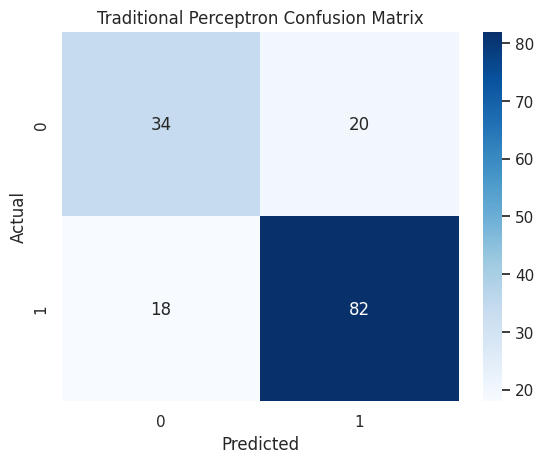

In [93]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_perceptron)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Traditional Perceptron Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Training Errors

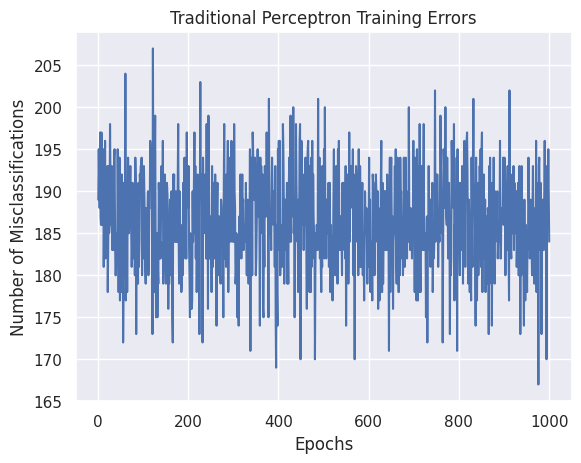

In [94]:
plt.plot(range(1, len(errors_perceptron) + 1), errors_perceptron)
plt.title('Traditional Perceptron Training Errors')
plt.xlabel('Epochs')
plt.ylabel('Number of Misclassifications')
plt.show()

Enhancing the Perceptron with Sigmoid Activation

In [95]:
y_train_sigmoid = np.where(y_train == -1, 0, 1)
y_test_sigmoid = np.where(y_test == -1, 0, 1)

Sigmod Function

In [96]:
def sigmoid_activation(z):
    return 1 / (1 + np.exp(-z))

 Logistic Regression Training Function

In [97]:
def train_logistic_regression(X, y, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    # Initialize weights and bias
    weights = np.zeros(n_features)
    bias = 0.0
    losses = []

    for epoch in range(epochs):
        # Linear model
        z = np.dot(X, weights) + bias
        # Activation function
        y_pred = sigmoid_activation(z)
        # Compute loss (binary cross-entropy)
        loss = - (y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15)).mean()
        losses.append(loss)
        # Compute gradients
        dw = np.dot(X.T, (y_pred - y)) / n_samples
        db = np.sum(y_pred - y) / n_samples
        # Update weights and bias
        weights -= learning_rate * dw
        bias -= learning_rate * db
        # Optionally, print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}')
    return weights, bias, losses


Train the new model

In [98]:
learning_rate = 0.01
epochs = 1000

weights_sigmoid, bias_sigmoid, losses_sigmoid = train_logistic_regression(
    X_train, y_train_sigmoid, learning_rate, epochs)


Epoch 100/1000, Loss: 0.6025
Epoch 200/1000, Loss: 0.5578
Epoch 300/1000, Loss: 0.5324
Epoch 400/1000, Loss: 0.5163
Epoch 500/1000, Loss: 0.5054
Epoch 600/1000, Loss: 0.4975
Epoch 700/1000, Loss: 0.4917
Epoch 800/1000, Loss: 0.4873
Epoch 900/1000, Loss: 0.4839
Epoch 1000/1000, Loss: 0.4812


Evaluate the Enhanced Perceptron Model

In [100]:
y_pred_probs = sigmoid_activation(np.dot(X_test, weights_sigmoid) + bias_sigmoid)
# Convert probabilities to class labels
y_pred_sigmoid = np.where(y_pred_probs >= 0.5, 1, 0)

Performance Metrics


In [101]:
accuracy_sigmoid = accuracy_score(y_test_sigmoid, y_pred_sigmoid)
print(f'Enhanced Perceptron (Sigmoid Activation) Accuracy: {accuracy_sigmoid * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test_sigmoid, y_pred_sigmoid))

Enhanced Perceptron (Sigmoid Activation) Accuracy: 75.97%
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.57      0.63        54
           1       0.79      0.86      0.82       100

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154



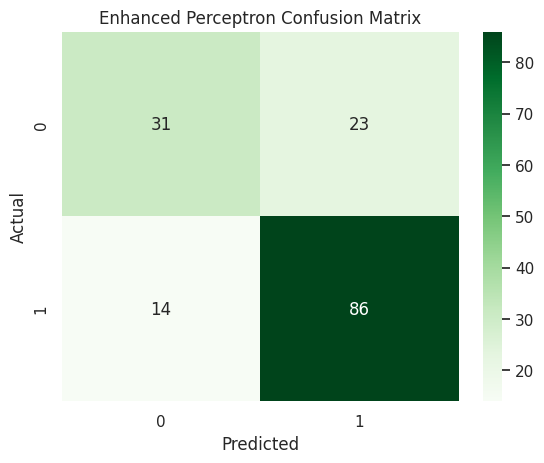

In [102]:
# Confusion Matrix
cm = confusion_matrix(y_test_sigmoid, y_pred_sigmoid)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Enhanced Perceptron Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Plot Training Loss


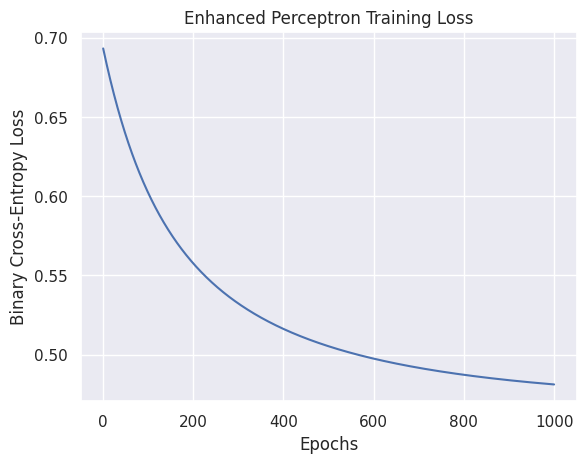

In [103]:
plt.plot(range(1, len(losses_sigmoid) + 1), losses_sigmoid)
plt.title('Enhanced Perceptron Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.show()

Comparision

In [104]:
print('Model Accuracies:')
print(f'Traditional Perceptron Accuracy: {accuracy_perceptron * 100:.2f}%')
print(f'Enhanced Perceptron (Sigmoid Activation) Accuracy: {accuracy_sigmoid * 100:.2f}%')

Model Accuracies:
Traditional Perceptron Accuracy: 75.32%
Enhanced Perceptron (Sigmoid Activation) Accuracy: 75.97%


In [105]:
print('Traditional Perceptron Classification Report:')
print(classification_report(y_test, y_pred_perceptron))

Traditional Perceptron Classification Report:
              precision    recall  f1-score   support

        -1.0       0.65      0.63      0.64        54
         1.0       0.80      0.82      0.81       100

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



In [106]:
print('Enhanced Perceptron Classification Report:')
print(classification_report(y_test_sigmoid, y_pred_sigmoid))


Enhanced Perceptron Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.57      0.63        54
           1       0.79      0.86      0.82       100

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154



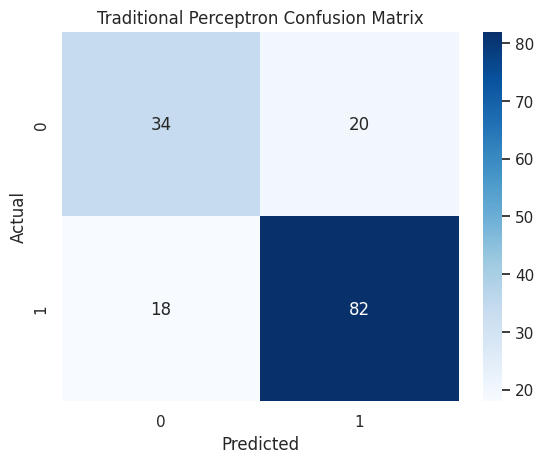

In [107]:
cm_perceptron = confusion_matrix(y_test, y_pred_perceptron)
sns.heatmap(cm_perceptron, annot=True, fmt='d', cmap='Blues')
plt.title('Traditional Perceptron Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

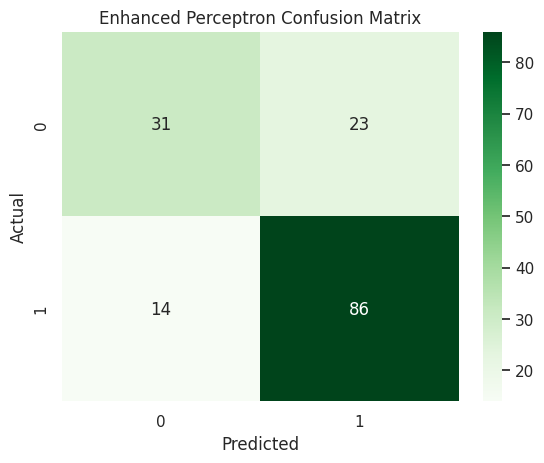

In [108]:
cm_sigmoid = confusion_matrix(y_test_sigmoid, y_pred_sigmoid)
sns.heatmap(cm_sigmoid, annot=True, fmt='d', cmap='Greens')
plt.title('Enhanced Perceptron Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [109]:
from sklearn.neural_network import MLPClassifier

# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam',
                    max_iter=1000, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Predict on test set
y_pred_mlp = mlp.predict(X_test)

# Evaluate performance
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f'MLP Accuracy: {accuracy_mlp * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test, y_pred_mlp))

MLP Accuracy: 77.92%
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.70      0.65      0.67        54
         1.0       0.82      0.85      0.83       100

    accuracy                           0.78       154
   macro avg       0.76      0.75      0.75       154
weighted avg       0.78      0.78      0.78       154



In [110]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (10,10)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01]
}

grid_search = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42),
                           param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_ * 100:.2f}%')

# Evaluate on test set
best_mlp = grid_search.best_estimator_
y_pred_best_mlp = best_mlp.predict(X_test)
accuracy_best_mlp = accuracy_score(y_test, y_pred_best_mlp)
print(f'Accuracy of best MLP on test set: {accuracy_best_mlp * 100:.2f}%')


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001, 'solver': 'sgd'}
Best cross-validation accuracy: 77.69%
Accuracy of best MLP on test set: 75.97%
